In [1]:
# merge_and_correlate.py

import numpy as np
from shapely.geometry import box
from rasterio.transform import from_bounds
from scipy.stats import pearsonr
from tqdm import tqdm
from data.dataset_v3 import ImageMaskDataset
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import rasterio
from rasterio.transform import Affine
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import rasterio
from rasterio.crs import CRS

import os
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

def merge_masks(
    dataset,
    resolution=100,
    output_dir="/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results",
    crs="EPSG:5070",
    num_irr_classes=4,
    state='Arizona',
    max_patches=20000,
    seed=42
):
    # Step 1: Randomly select up to 20K valid patches
    all_bounds = []
    valid_samples = []

    indices = list(range(len(dataset)))
    random.seed(seed)
    random.shuffle(indices)

    selected = 0
    for i in tqdm(indices, desc="Scanning and selecting samples"):
        if selected >= max_patches:
            break
        sample = dataset[i]
        if sample['irr_mask'] is None:
            continue
        bounds = sample['polygon'].bounds
        all_bounds.append(bounds)
        valid_samples.append((sample, bounds))
        selected += 1

    print(f"\n✅ Selected {len(valid_samples)} valid samples (out of {len(dataset)})")

    # Step 2: Compute global raster bounds and shape
    bounds_array = np.array(all_bounds)
    xmin, ymin = bounds_array[:, 0].min(), bounds_array[:, 1].min()
    xmax, ymax = bounds_array[:, 2].max(), bounds_array[:, 3].max()

    width = int(np.ceil((xmax - xmin) / resolution))
    height = int(np.ceil((ymax - ymin) / resolution))
    transform = from_bounds(xmin, ymin, xmax, ymax, width, height)
    os.makedirs(output_dir, exist_ok=True)

    # Step 3: Initialize rasters
    crop_classes = np.zeros((255, height, width), dtype=np.float32)  # fixed 255 channels
    irr_stack = np.zeros((num_irr_classes, height, width), dtype=np.uint32)
    count_raster = np.zeros((height, width), dtype=np.uint32)

    for sample, bounds in tqdm(valid_samples, desc="Merging patches"):
        crop = sample['crop_mask'].squeeze().numpy()
        irr = sample['irr_mask'].squeeze().numpy().astype(np.uint8)

        h, w = crop.shape
        x0 = int((bounds[0] - xmin) / resolution)
        y0 = int((ymax - bounds[3]) / resolution)
        y1 = min(y0 + h, height)
        x1 = min(x0 + w, width)

        h_clip = y1 - y0
        w_clip = x1 - x0
        if h_clip <= 0 or w_clip <= 0:
            continue

        crop = crop[:h_clip, :w_clip]
        irr = irr[:h_clip, :w_clip]

        unique_vals = np.unique(crop)
        for val in unique_vals:
            if val <= 0.0 or val > 1.0:
                continue
            crop_type = int(round(val * 255))
            if crop_type == 0 or crop_type > 255:
                continue
            mask = (crop == val).astype(np.float32)
            crop_classes[crop_type - 1, y0:y1, x0:x1] += mask  # index from 0

        for c in range(num_irr_classes):
            mask = (irr == c).astype(np.uint8)
            irr_stack[c, y0:y1, x0:x1] += mask

        count_raster[y0:y1, x0:x1] += 1

    # Step 4: Post-process outputs
    irr_raster = np.argmax(irr_stack, axis=0).astype(np.uint8)
    valid_mask = (count_raster > 0).astype(np.uint8)
    count_raster[count_raster == 0] = 1  # avoid division by zero

    crop_stack = (crop_classes / count_raster).astype(np.float32)

    def save_raster(path, data, count=1, dtype="uint8"):
        with rasterio.open(
            path, "w", driver="GTiff",
            height=height, width=width, count=count,
            dtype=dtype, transform=transform, crs=CRS.from_string(crs)
        ) as dst:
            if count == 1:
                dst.write(data, 1)
            else:
                dst.write(data)

    save_raster(os.path.join(output_dir, f"irrigation_majority_{state}.tif"), irr_raster, count=1, dtype="uint8")
    save_raster(os.path.join(output_dir, f"valid_mask_{state}.tif"), valid_mask, count=1, dtype="uint8")
    save_raster(os.path.join(output_dir, f"crop_distribution_{state}.tif"), crop_stack, count=255, dtype="float32")

    print(f"\n✅ Merged and saved {selected} patches for {state}")
    print(f"✅ Files saved to: {output_dir}")



import rasterio
import numpy as np
from scipy.stats import pearsonr

def load_and_compute_crop_irr_correlation(
    crop_path: str,
    irr_path: str,
    valid_path: str,
    num_irr_classes: int = 4
):
    """
    Loads raster files and computes correlation between crop fractions and irrigation classes.
    Returns a nested dict[crop_id][irr_class] = pearson_corr
    """
    # --- Load crop multi-band raster ---
    with rasterio.open(crop_path) as src:
        crop_stack = src.read()  # shape: (num_crops, H, W)
        crop_ids = list(range(1, crop_stack.shape[0] + 1))  # assume band i = crop i

    crop_rasters = {crop_id: crop_stack[i] for i, crop_id in enumerate(crop_ids)}

    # --- Load categorical irrigation raster ---
    with rasterio.open(irr_path) as src:
        irr_raster = src.read(1)  # shape: (H, W)

    # --- Load valid pixel mask ---
    with rasterio.open(valid_path) as src:
        valid_mask = src.read(1).astype(bool)

    irr_flat = irr_raster[valid_mask].flatten()
    correlations = {}

    for crop_id, crop_band in crop_rasters.items():
        crop_flat = crop_band[valid_mask].flatten()
        crop_corrs = {}

        for irr_class in range(num_irr_classes):
            irr_binary = (irr_flat == irr_class).astype(np.float32)
            if np.std(irr_binary) == 0 or np.std(crop_flat) == 0:
                corr = 0.0  # fallback for degenerate case
            else:
                corr = pearsonr(crop_flat, irr_binary)[0]
            crop_corrs[irr_class] = corr

        correlations[int(crop_id)] = crop_corrs

    return correlations



def compute_text_irrigation_correlation(dataset):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = []
    labels = []

    for i in tqdm(range(len(dataset)), desc="Text-Irrigation correlation"):
        sample = dataset[i]
        if sample['irr_mask'] is None:
            continue
        text = sample['text_prompt']
        emb = model.encode(text)
        irr = sample['irr_mask'].squeeze().numpy()
        avg_irr = np.mean(irr > 0)
        embeddings.append(emb)
        labels.append(avg_irr)

    embeddings = np.array(embeddings)
    labels = np.array(labels)
    correlations = [pearsonr(embeddings[:, i], labels)[0] for i in range(embeddings.shape[1])]
    return correlations, np.mean(np.abs(correlations))

import pandas as pd

def save_correlation_to_csv(correlations: dict, output_path: str):
    """
    Saves nested dict[crop_id][irr_class] = correlation to CSV.
    Each row is a crop; columns are IrrClass_0, IrrClass_1, ...
    """
    df = pd.DataFrame.from_dict(correlations, orient='index')
    df.index.name = "CropID"
    df.columns = [f"IrrClass_{c}" for c in df.columns]
    df.to_csv(output_path)
    print(f"✅ Saved correlation CSV to: {output_path}")

# if __name__ == "__main__":
#     data_dir = "/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/Train-Test-Split"
#     dataset = ImageMaskDataset(
#         data_dir=data_dir,
#         states=[('Arizona', 1.0)],
#         train_type='cross-state',
#         split='train',
#         transform=False,
#         vision_indices=['image']
#     )

#     width, height, transform, valid_samples, xmin, ymin, xmax, ymax, resolution = merge_masks(dataset)
#     crop_rasters, irr_raster, valid_mask = find_crop_irr_raster(width, height, transform, valid_samples, xmin, ymin, xmax, ymax, resolution)
#     crop_irr_corr = compute_crop_irr_correlation(crop_rasters, irr_raster, valid_mask)
#     print("\n✅ Crop-Irrigation Correlation per Crop Type:")
#     for crop_id, corr in crop_irr_corr.items():
#         print(f"  Crop {crop_id:3d} → Corr: {corr:.4f}")

#     correlations, mean_corr = compute_text_irrigation_correlation(dataset)
#     print(f"\n📝 Mean absolute correlation (text → irrigation): {mean_corr:.4f}")


In [2]:
data_dir = "/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/Train-Test-Split"
state = 'Georgia'
dataset = ImageMaskDataset(
        data_dir=data_dir,
        states=[(state, 1.0)],
        train_type='cross-state',
        split='train',
        transform=False,
        vision_indices=['image']
    )

merge_masks(dataset, state=state)

Scanning and selecting samples: 100%|██████████| 7083/7083 [11:39<00:00, 10.12it/s]



✅ Selected 7083 valid samples (out of 7083)


Merging patches: 100%|██████████| 7083/7083 [00:24<00:00, 291.67it/s]



✅ Merged and saved 7083 patches for Georgia
✅ Files saved to: /project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results


In [5]:
state = 'Georgia'
crop_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_distribution_{state}.tif'
irr_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/irrigation_majority_{state}.tif'
valid_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/valid_mask_{state}.tif'
output_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_irr_corr_{state}.csv'
corr = load_and_compute_crop_irr_correlation(crop_path,
    irr_path,
    valid_path)
save_correlation_to_csv(corr,output_path=output_path)

✅ Saved correlation CSV to: /project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_irr_corr_Georgia.csv


In [2]:
###### crop-irr correlation

from collections import defaultdict

from collections import defaultdict
from tqdm import tqdm
CROP_GROUPS_CDL = {
    "Grain": [1, 3, 4, 21, 22, 23, 24, 27, 28, 29, 30],
    "Oilseed": [5, 6, 31, 32, 33, 34, 35],
    "Legume": [10, 42, 51, 52, 53],
    "Vegetable": [12, 43, 46, 47, 48, 49, 50, 54, 56, 206, 207, 208, 214, 216, 219, 227, 229, 243, 244],
    "Orchard": [66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 204, 210, 211, 212, 215, 217, 218, 220, 223],
    "Forage": [36, 37, 38, 39, 58, 59, 60],
    "Specialty": [2, 11, 13, 14, 41, 44, 45, 55, 57, 221, 222, 242],
    "DoubleCrop/Other": list(range(26, 67)) + list(range(81, 95)),  # includes double crop combinations and other mixed classes
}
def load_and_compute_group_crop_irr_percentage(
    crop_path: str,
    irr_path: str,
    valid_path: str,
    crop_groups: dict = CROP_GROUPS_CDL,
    num_irr_classes: int = 4  # assume classes: 0 (no irrigation), 1, 2, 3
):
    import rasterio
    import numpy as np

    with rasterio.open(crop_path) as src:
        crop_stack = src.read()  # shape: (num_crops, H, W)

    crop_ids = list(range(1, crop_stack.shape[0] + 1))
    crop_rasters = {crop_id: crop_stack[i] for i, crop_id in enumerate(crop_ids)}

    with rasterio.open(irr_path) as src:
        irr_raster = src.read(1)

    with rasterio.open(valid_path) as src:
        valid_mask = src.read(1).astype(bool)

    irr_raster = irr_raster[valid_mask]
    group_percentages = {}

    for group_name, crop_ids in crop_groups.items():
        combined_crop = np.zeros_like(irr_raster, dtype=np.float32)

        for cid in crop_ids:
            if cid in crop_rasters:
                combined_crop += crop_rasters[cid][valid_mask]

        # Only include irrigated classes (1, 2, 3)
        class_area = {}
        total_irrigated_area = 0.0

        for irr_class in range(1, num_irr_classes):  # skip 0 (non-irrigated)
            irr_mask = (irr_raster == irr_class)
            area = combined_crop[irr_mask].sum()
            class_area[irr_class] = area
            total_irrigated_area += area

        if total_irrigated_area == 0:
            continue  # skip groups with no irrigation at all

        # Normalize percentages so that sum = 100
        method_percentages = {
            irr_class: round((area / total_irrigated_area) * 100, 2)
            for irr_class, area in class_area.items()
        }

        group_percentages[group_name] = method_percentages

    return group_percentages



In [4]:
state = 'Arizona'
crop_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_distribution_{state}.tif'
irr_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/irrigation_majority_{state}.tif'
valid_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/valid_mask_{state}.tif'
output_path = f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_irr_pct_{state}_group.csv'
pct = load_and_compute_group_crop_irr_percentage(crop_path,
    irr_path,
    valid_path)
save_correlation_to_csv(pct,output_path=output_path)

✅ Saved correlation CSV to: /project/biocomplexity/wyr6fx(Nibir)/NeurIPS_Irrigation_Mapping_Model/Results/crop_irr_pct_Arizona_group.csv


In [22]:
crop_stack.shape

(69, 4986, 6358)

In [5]:
import torch
import numpy as np
import geopandas as gpd
from shapely import wkt
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from tqdm import tqdm

# --- Set state ---
# state = "Arizona"  # or any state you want

# --- Load polygons ---
gdf = gpd.read_file(f'/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/Agcensus/{state}_Irrigation.geojson')
gdf = gdf.to_crs("EPSG:5070")

# --- Define global raster extent ---
xmin, ymin, xmax, ymax = gdf.total_bounds
resolution = 30  # meters
width = int(np.ceil((xmax - xmin) / resolution))
height = int(np.ceil((ymax - ymin) / resolution))
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# --- Initialize global minimum prediction raster ---
min_pred_map = np.full((height, width), fill_value=255, dtype=np.uint8)

# --- Inference loop over patches ---
model.eval()
for batch in tqdm(data_module.train_dataloader(), desc="Aggregating min predictions"):
    with torch.no_grad():
        polygons = batch['polygon']  # list of WKT strings
        batch = {k: v.to('cuda') for k, v in batch.items() if isinstance(v, torch.Tensor)}
        preds = model(batch)['predictions'].argmax(dim=1).cpu().numpy()

    for i in range(preds.shape[0]):
        patch_mask = preds[i]  # shape: (H, W)
        poly = wkt.loads(polygons[i])
        bounds = poly.bounds

        h, w = patch_mask.shape
        patch_transform = from_bounds(*bounds, w, h)

        # Mask out only area inside the polygon
        poly_raster = rasterize(
            [(poly, 1)],
            out_shape=(h, w),
            transform=patch_transform,
            fill=0,
            dtype=np.uint8
        )
        patch_mask = patch_mask * poly_raster

        # Get pixel coordinates in global raster
        x0 = int((bounds[0] - xmin) / resolution)
        y0 = int((ymax - bounds[3]) / resolution)
        x1 = min(x0 + w, width)
        y1 = min(y0 + h, height)
        h_clip = y1 - y0
        w_clip = x1 - x0

        if h_clip <= 0 or w_clip <= 0:
            continue

        patch_mask = patch_mask[:h_clip, :w_clip].astype(np.uint8)

        # Apply np.minimum only where the patch has a valid value (>0)
        target = min_pred_map[y0:y1, x0:x1]
        
        np.minimum(target, patch_mask, out=target, where=(patch_mask > 0))

# --- Optionally save the result ---
# import rasterio
# with rasterio.open(
#     f"min_prediction_{state}.tif", 'w',
#     driver='GTiff',
#     height=height, width=width,
#     count=1, dtype=np.uint8,
#     crs="EPSG:5070",
#     transform=transform,
# ) as dst:
#     dst.write(min_pred_map, 1)


Aggregating min predictions: 100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


In [6]:
# --- Filter polygons based on min_pred_map ---
valid_rows = []
irrigated_counts = []

# Optional: group if needed
gdf_group = gdf.groupby(['geometry', 'County'])['Irrigated Acres'].sum().reset_index()

for idx, geom in tqdm(enumerate(gdf_group.geometry), total=len(gdf_group)):
    bounds = geom.bounds
    x0 = int((bounds[0] - xmin) / resolution)
    y0 = int((ymax - bounds[3]) / resolution)
    x1 = int((bounds[2] - xmin) / resolution)
    y1 = int((ymax - bounds[1]) / resolution)

    h = y1 - y0
    w = x1 - x0
    if h <= 0 or w <= 0 or x1 > width or y1 > height:
        continue

    local_transform = from_bounds(*bounds, w, h)

    poly_mask = rasterize(
        [(geom, 1)],
        out_shape=(h, w),
        transform=local_transform,
        fill=0,
        dtype=np.uint8
    )

    # Extract the region of the prediction raster
    pred_crop = min_pred_map[y0:y1, x0:x1]

    if not np.any(poly_mask):
        continue

    irrigated_pixels = ((pred_crop == 1) * poly_mask).sum()
    if irrigated_pixels == 0:
        continue

    valid_rows.append(idx)
    irrigated_counts.append(irrigated_pixels)

# --- Save filtered output ---
gdf_group = gdf_group.loc[valid_rows].copy()
gdf_group['irrigated_pixels'] = irrigated_counts
# gdf_group.to_file(f"predicted_irrigated_min_{state}.geojson", driver="GeoJSON")


100%|██████████| 368/368 [00:03<00:00, 97.02it/s] 


In [8]:
gdf_group['irrigation_discovered'] = gdf_group['irrigated_pixels']*0.2223945

In [10]:
gdf_group[['Irrigated Acres','irrigation_discovered']].sum()

Irrigated Acres          680168.000000
irrigation_discovered    394635.037149
dtype: float64

In [11]:
true = gdf_group['Irrigated Acres'].astype(float).values
pred = gdf_group['irrigation_discovered'].astype(float).values

rmse = np.sqrt(np.mean((true - pred) ** 2))
print(f"RMSE: {rmse:.4f}")

RMSE: 58047.2753


In [31]:
gdf['Irrigated Acres'].sum()

3363911

In [33]:
gdf_group[['Irrigated Acres','irrigation_discovered']].sum()

Irrigated Acres          7.057870e+05
irrigation_discovered    1.639509e+06
dtype: float64

In [36]:
len(gdf_group

47

In [39]:
gdf['Irrigated Acres'].sum()

3363911

In [10]:
data_dir = "/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/Train-Test-Split"
state = 'Arizona'
dataset = ImageMaskDataset(
        data_dir=data_dir,
        states=[(state, 1.0)],
        train_type='unsupervised',
        split='train',
        transform=False,
        vision_indices=['image']
    )

In [12]:
dataset[0]

{'image_path': '/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/patches/Arizona/2023/003cda47-2e9e-4574-a023-e97c5c0ad9b2/L2A_T11SQT_A041980_20230706T182312/patch_10080_2016.tif',
 'split': 'train',
 'rgb': tensor([[[0.3961, 0.3922, 0.3882,  ..., 0.1216, 0.1216, 0.1216],
          [0.3765, 0.3725, 0.3725,  ..., 0.1294, 0.1294, 0.1216],
          [0.3804, 0.3765, 0.3725,  ..., 0.1216, 0.1294, 0.1294],
          ...,
          [0.4000, 0.4667, 0.4745,  ..., 0.6745, 0.6706, 0.6863],
          [0.1922, 0.2118, 0.2588,  ..., 0.6588, 0.6784, 0.7020],
          [0.1490, 0.1451, 0.1490,  ..., 0.6510, 0.6980, 0.6902]],
 
         [[0.3294, 0.3294, 0.3294,  ..., 0.2196, 0.2196, 0.2196],
          [0.3176, 0.3216, 0.3216,  ..., 0.2196, 0.2196, 0.2196],
          [0.3176, 0.3176, 0.3216,  ..., 0.2235, 0.2196, 0.2196],
          ...,
          [0.3647, 0.4000, 0.4078,  ..., 0.5490, 0.5490, 0.5451],
          [0.2706, 0.2745, 0.2941,  ..., 0.5333, 0.5490, 0.5686],
          [0.2471, 0.2

In [9]:
dataset[0]

{'image_path': '/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data/patches/Georgia/2023/02b1cac4-9243-45e6-9db6-dfec8a4ebad4/L2A_T16SGB_A033342_20230725T162050/patch_0_10528.tif',
 'split': 'train',
 'rgb': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4627, 0.4667, 0.4824,  ..., 0.4510, 0.4510, 0.4471],
          [0.4627, 0.4627, 0.4627,  ..., 0.4471, 0.4510, 0.4510],
          [0.4627, 0.4627, 0.4588,  ..., 0.4471, 0.4510, 0.4510]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5176, 0.5216, 0.5255,  ..., 0.5137, 0.5059, 0.5059],
          [0.5216, 0.5176, 0.5176,  ..., 0.5137, 0.5059, 0.5098],
          [0.5216, 0.5176

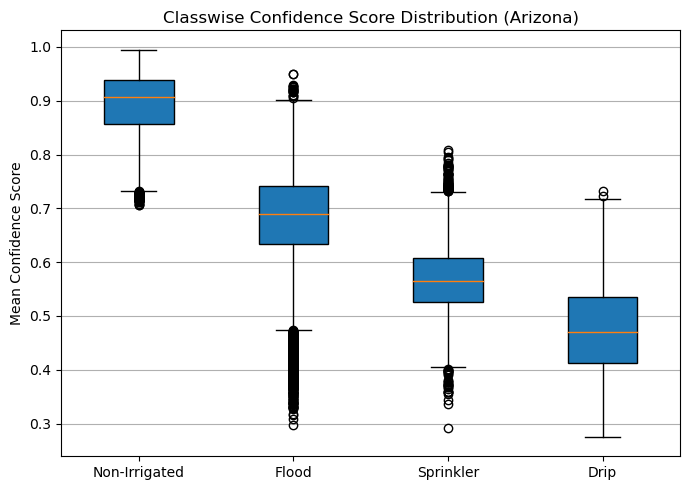

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# === Configuration ===
state = "Arizona"
base_dir = f"/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data"
conf_dir = os.path.join(base_dir, "generated_confes", state)
label_dir = os.path.join(base_dir, "generated_labeles", state)

# === Load all confidence and label paths ===
conf_paths = sorted(glob(os.path.join(conf_dir, "**", "*.npy"), recursive=True))

# === Initialize lists for each class ===
classwise_confidence = {0: [], 1: [],2:[],3:[]}  # 0 = non-irrigated, 1 = irrigated

for conf_path in conf_paths:
    # Get matching label path
    label_path = conf_path.replace("generated_conf", "generated_label")
    if not os.path.exists(label_path):
        continue  # skip if label is missing

    # Load data
    conf_map = np.load(conf_path)
    label_map = np.load(label_path)

    for cls in [0, 1,2,3]:
        mask = (label_map == cls)
        if np.any(mask):
            classwise_confidence[cls].append(np.mean(conf_map[mask]))

# === Create Box Plot ===
plt.figure(figsize=(7, 5))
plt.boxplot(
    [classwise_confidence[0], classwise_confidence[1],classwise_confidence[2],classwise_confidence[3]],
    vert=True,
    patch_artist=True,
    labels=["Non-Irrigated", "Flood",'Sprinkler','Drip']
)
plt.ylabel("Mean Confidence Score")
plt.title(f"Classwise Confidence Score Distribution ({state})")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# === Configuration ===
states = [
    "Arizona", "Florida", "Georgia", "Texas", "Arkansas", "California",
    "Nebraska", "Ohio", "North Carolina", "South Carolina", "Pennsylvania",
    "West Virginia", "New Jersey", "Michigan", "Indiana", "Maryland", "Oregon"
]
base_dir = "/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_irrigation_data"
class_names = {0: "Non-Irrigated", 1: "Flood", 2: "Sprinkler", 3: "Drip"}


# === Worker function ===
def process_state(state):
    state_records = []
    conf_dir = os.path.join(base_dir, "generated_confes", state)
    conf_paths = sorted(glob(os.path.join(conf_dir, "**", "*.npy"), recursive=True))

    for conf_path in conf_paths:
        label_path = conf_path.replace("generated_conf", "generated_label")
        if not os.path.exists(label_path):
            continue

        conf_map = np.load(conf_path)
        label_map = np.load(label_path)

        for cls in range(4):
            mask = (label_map == cls)
            if not np.any(mask):
                continue
            mean_conf = np.mean(conf_map[mask])
            state_records.append({
                "State": state,
                "Class": class_names[cls],
                "Confidence": mean_conf
            })
    return state_records


# === Run in Parallel ===
all_records = []
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_state, state): state for state in states}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing States"):
        all_records.extend(future.result())

# === Create DataFrame ===
df = pd.DataFrame(all_records)
print("DataFrame columns:", df.columns.tolist())
print(df.head())

# === Plot ===
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Class", y="Confidence", hue="State")
plt.title("Classwise Confidence Distribution Across States")
plt.ylabel("Mean Confidence Score")
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Processing States:  94%|█████████▍| 16/17 [1:27:32<17:12, 1032.63s/it]